In [1]:
import copy
import csv
from enum import Enum
import io
import json
import os
import typing as t

import cv2
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
)
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights, resnet50

In [2]:
from utils import (
    show_photos, 
    create_dataloader,
    train_epoch,
    test_epoch,
    plot_history,
    print_model_params_required_grad,
    PUBLIC_DATA_FOLDER_PATH,
    PUBLIC_DATA_DESCRIPTION_PATH,
)

In [3]:
PUBLIC_DATA_FOLDER_PATH = '/tmp/cs/competition_photo_mid'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

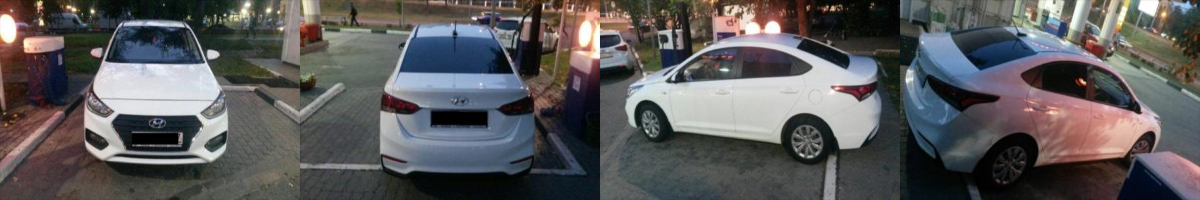

In [4]:
pass_id = '000f43a6549ad26d'
photos = []
for side in ['front', 'back', 'left', 'right']:
    with open(f'{PUBLIC_DATA_FOLDER_PATH}/{pass_id}_{side}', 'rb') as file:
        photos.append(file.read())
show_photos(photos)

In [5]:
description = pd.read_csv(PUBLIC_DATA_DESCRIPTION_PATH, index_col='filename').sort_index()
description.head()

,pass_id,plan_side,fact_side,fraud_verdict,fraud_probability,damage_verdict,damage_probability
filename,,,,,,,
00015b960a1c013e_back,00015b960a1c013e,back,back,DARK_PHOTO,1.000000,BAD_PHOTO,0.8
00015b960a1c013e_front,00015b960a1c013e,front,front,DARK_PHOTO,0.666667,BAD_PHOTO,1.0
00015b960a1c013e_left,00015b960a1c013e,left,unknown,DARK_PHOTO,0.666667,BAD_PHOTO,0.6
00015b960a1c013e_right,00015b960a1c013e,right,unknown,DARK_PHOTO,0.666667,BAD_PHOTO,1.0
0001f673ef360c58_back,0001f673ef360c58,back,back,ALL_GOOD,0.666667,NO_DEFECT,1.0


**Инвертируем damage_verdict если damage_probability < 0.33**

In [6]:
description.loc[(description['damage_verdict'] == 'NO_DEFECT') & (description['damage_probability'] < 0.33), 'damage_verdict'] = 'DEFECT'
description.loc[~(description['damage_verdict'] == 'NO_DEFECT') & (description['damage_probability'] < 0.33), 'damage_verdict'] = 'NO_DEFECT'

In [7]:
description[description.pass_id == '001c07aa1e3edf7e']

,pass_id,plan_side,fact_side,fraud_verdict,fraud_probability,damage_verdict,damage_probability
filename,,,,,,,
001c07aa1e3edf7e_back,001c07aa1e3edf7e,back,back,ALL_GOOD,1.0,NO_DEFECT,1.0
001c07aa1e3edf7e_front,001c07aa1e3edf7e,front,front,ALL_GOOD,1.0,NO_DEFECT,1.0
001c07aa1e3edf7e_left,001c07aa1e3edf7e,left,front,ALL_GOOD,1.0,NO_DEFECT,1.0
001c07aa1e3edf7e_right,001c07aa1e3edf7e,right,back,ALL_GOOD,1.0,NO_DEFECT,0.8


In [8]:
class CarSide(Enum):
    FRONT = 0
    BACK = 1
    LEFT = 2
    RIGHT = 3
    UNKNOWN = 5
    
class FraudResolution(Enum):
    ALL_GOOD = 0
    LACK_OF_PHOTOS = 1
    BLURRY_PHOTO = 2
    SCREEN_PHOTO = 3
    DARK_PHOTO = 4
    INCOMPLETE_CAPTURE = 5
    
class DamageResolution(Enum):
    NO_DEFECT = 0
    DEFECT = 1
    BAD_PHOTO = 2

In [9]:
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_STD = [0.229, 0.224, 0.225]
RESIZE_SIZE = (224, 224)


def pil_open(image_data: bytes) -> Image:
    return Image.open(io.BytesIO(image_data))


def preprocess(image_data: t.Optional[bytes]) -> torch.Tensor:
    return transforms.Compose([
        transforms.Lambda(pil_open),
        transforms.ToTensor(),
        transforms.Resize(RESIZE_SIZE),
        transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_STD),
    ])(image_data)

In [10]:
def get_damage_target(row):
    return int(
        row['plan_side'] != row['fact_side'] or 
        row['fraud_verdict'] != 'ALL_GOOD' or
        row['damage_verdict'] != 'NO_DEFECT'
    )

columns = ['plan_side', 'fraud_verdict', 'damage_verdict', 'fact_side']
damage_target = description[columns].apply(lambda x: get_damage_target(x), axis=1)

In [11]:
damage_target.value_counts()

1    114360
0     67445
Name: count, dtype: int64

In [12]:
BATCH_SIZE = 64
TRAIN_FRACTION = 0.7

total_size = damage_target.shape[0]
train_size = int(total_size * TRAIN_FRACTION)


train_loader = create_dataloader(
    img_dir_path=PUBLIC_DATA_FOLDER_PATH,
    target_map=damage_target[:train_size].to_dict(),
    description=description,
    batch_size=BATCH_SIZE,
    preprocessor=preprocess,
    num_load_workers=0,
)

test_loader = create_dataloader(
    img_dir_path=PUBLIC_DATA_FOLDER_PATH,
    target_map=damage_target[train_size:total_size].to_dict(),
    description=description,
    batch_size=BATCH_SIZE,
    preprocessor=preprocess,
    num_load_workers=0,
)

In [13]:
def train_model(
    model, 
    device, 
    train_loader, 
    test_loader, 
    epochs, 
    criterion, 
    optimizer, 
    scheduler=None, 
    save_best_model=True
):
    best_test_loss = None
    best_state_dict = None
    train_loss_history = []
    train_acc_history = []
    test_loss_history = []
    test_acc_history = []
    
    model = model.to(device)
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}')
        train_loss, train_acc = train_epoch(
            model, 
            device,
            train_loader, 
            criterion, 
            optimizer
        )
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)
        
        if scheduler is not None:
            scheduler.step()
        
        test_loss, test_acc = test_epoch(model, device, test_loader, criterion)
        test_loss_history.append(test_loss)
        test_acc_history.append(test_acc)
        
        if best_test_loss is None or test_loss < best_test_loss:
            best_test_loss = test_loss
            best_state_dict = copy.deepcopy(model.state_dict())
        
        clear_output()
        plot_history(
            train_loss_history, 
            test_loss_history, 
            train_acc_history, 
            test_acc_history
        )
    
    if save_best_model:
        model.load_state_dict(best_state_dict)
    
    return {
        'train_loss': train_loss_history, 
        'test_loss': test_loss_history,
        'train_acc': train_acc_history,
        'test_acc': test_acc_history
    }

### ResNet18

In [14]:
RESNET18_WEIGHTS_PATH = 'resnet18-5c106cde.pth'

# load pretrained model
model = resnet18()
model.load_state_dict(torch.load(RESNET18_WEIGHTS_PATH, weights_only=True))

for param in model.parameters():
    param.requires_grad = False

# replace classifier
model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
    torch.nn.Sigmoid(),
)

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.3)

def BCELoss_class_weighted(weights):
    
    def loss(pred, target):
        pred = torch.clamp(pred, min=1e-7, max=1-1e-7)
        bce = -weights[1] * target * torch.log(pred) - (1 - target) * weights[0] * torch.log(1 - pred)
        return torch.sum(bce)

    return loss

criterion = BCELoss_class_weighted(weights=[0.5, 0.5])

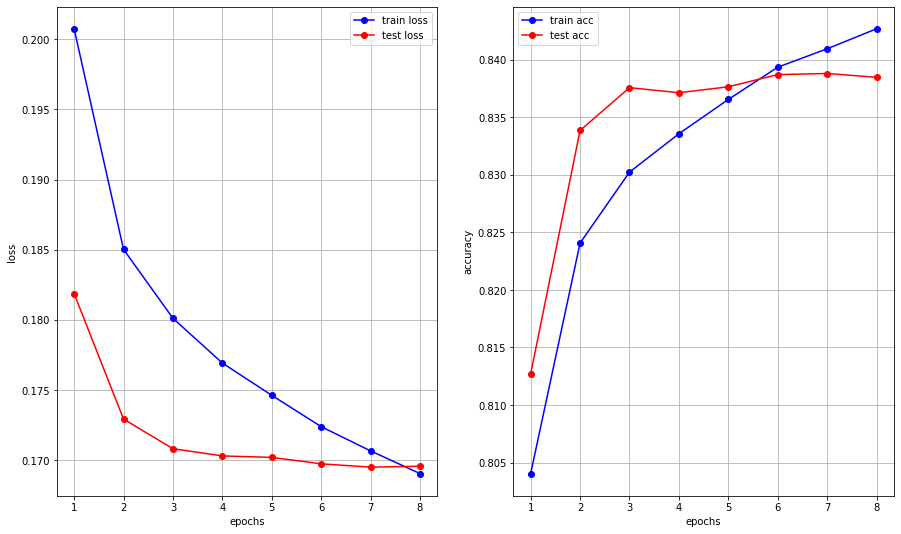

In [16]:
print_model_params_required_grad(model)

resnet_simple_fraud_log = train_model(
    model=model, 
    device=device,
    train_loader=train_loader, 
    test_loader=test_loader, 
    epochs=8, 
    criterion=criterion, 
    optimizer=optimizer, 
)

In [17]:
from sklearn.metrics import roc_auc_score

from utils import get_predictions

In [18]:
test_predictions = get_predictions(model, device, test_loader)

  0%|          | 0/853 [00:00<?, ?it/s]

In [19]:
unique_plan_sides = test_predictions.groupby('pass_id')['plan_side'].nunique()

def make_complex_target(row):
    real = int(
        row.plan_side != row.fact_side or 
        row.fraud_verdict != 'ALL_GOOD' or
        row.damage_verdict != 'NO_DEFECT' or
        row.pass_id in unique_plan_sides.loc[unique_plan_sides != 4].index
    )
    return pd.Series(
        data=[row.pass_id, real, row.prediction],
        index=['pass_id', 'real', 'pred'],
    )

# All predictions for each vehicle are aggregated into a single value, 
# and the metric is calculated based on the inspections.
test_verdicts = test_predictions.merge(
    description, 
    on=['pass_id', 'plan_side']
).apply(make_complex_target, axis=1).groupby('pass_id').max()

test_verdicts.head()

,real,pred
pass_id,,
a1240a46c165f6ca,1,0.999998
a1252381f49a5101,1,0.996754
a1256f6b65a2193b,1,0.915694
a12659d9dceef2aa,1,0.999930
a1289c09d5a573cc,1,0.973869


In [20]:
score = roc_auc_score(test_verdicts.real, test_verdicts.pred)
print(f'simple fraud target roc_auc_score: {score}')

simple fraud target roc_auc_score: 0.9502274335650933


In [30]:
from sklearn.metrics import classification_report

prediction = (test_verdicts.pred > 0.5).astype(int)
print(classification_report(test_verdicts.real, prediction))

              precision    recall  f1-score   support

           0       0.52      0.81      0.63      1348
           1       0.98      0.92      0.95     12294

    accuracy                           0.91     13642
   macro avg       0.75      0.87      0.79     13642
weighted avg       0.93      0.91      0.92     13642



In [35]:
test_verdicts.loc[(test_verdicts.pred > 0.5) & (test_verdicts.real == 0)]

,real,pred
pass_id,,
a15db0d0fb4912b0,0,0.840444
a184997b095f8fef,0,0.883894
a1b9792ed73befa9,0,0.504855
a1ded85cbda8a133,0,0.957274
a252acee1fe89545,0,0.674949
...,...,...
e57b567800123c7b,0,0.687781
e58d5eee45cacea4,0,0.686788
e5946c680bae9334,0,0.659005


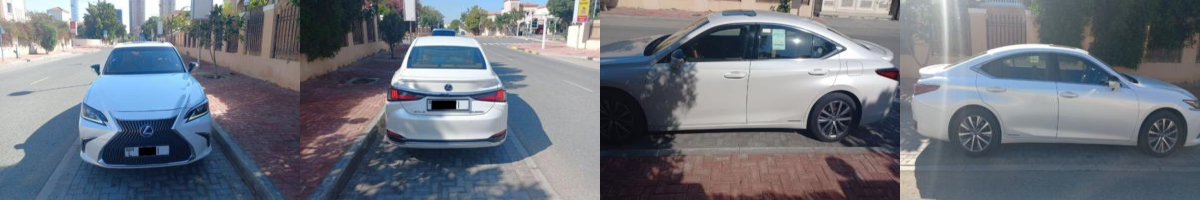

In [38]:
pass_id = 'a1b9792ed73befa9'
photos = []
for side in ['front', 'back', 'left', 'right']:
    with open(f'{PUBLIC_DATA_FOLDER_PATH}/{pass_id}_{side}', 'rb') as file:
        photos.append(file.read())
show_photos(photos)

**Последнее обучение ровно до этого момента, дальше предыдущие попытки и оформление архива**

In [22]:
solution_script = '''
import typing as t
import io

import pandas as pd
from PIL import Image
import torch
import torchvision.transforms as transforms

from utils import (
    get_predictions, 
    create_dataloader,
    PRIVATE_DATA_FOLDER_PATH, 
    PRIVATE_DATA_DESCRIPTION_PATH,
)

BATCH_SIZE = 64
IMAGENET_RGB_MEAN = [0.485, 0.456, 0.406]
IMAGENET_RGB_STD = [0.229, 0.224, 0.225]
RESIZE_SIZE = (224, 224)


def pil_open(image_data: bytes) -> Image:
    return Image.open(io.BytesIO(image_data))


def preprocess(image_data: t.Optional[bytes]) -> torch.Tensor:
    return transforms.Compose([
        transforms.Lambda(pil_open),
        transforms.ToTensor(),
        transforms.Resize(RESIZE_SIZE),
        transforms.Normalize(IMAGENET_RGB_MEAN, IMAGENET_RGB_STD),
    ])(image_data)

device = torch.device('cpu')
model = torch.load('baseline_damage.pt', map_location=device)

description = pd.read_csv(PRIVATE_DATA_DESCRIPTION_PATH, index_col='filename').sort_index()
# there is no real target in private data description
dummy_target = {key: 0 for key in description.index}

val_loader = create_dataloader(
    img_dir_path=PRIVATE_DATA_FOLDER_PATH,
    target_map=dummy_target,
    description=description,
    batch_size=BATCH_SIZE,
    preprocessor=preprocess,
    num_load_workers=0,
)

solution = get_predictions(model, device, val_loader)
solution = solution[['pass_id', 'prediction']].groupby('pass_id').max()
solution.to_csv('./predictions.csv')
'''

In [23]:
# build the .zip to submit
import zipfile
import datetime

def make_zip_submission(model_path, solution_script):

    with open('run.py', 'w') as f_run:
        f_run.write(solution_script)

    with open('run.sh', 'w') as f_run_sh:
        f_run_sh.write('python run.py')

    with open('prepare.py', 'w') as f_run:
        f_run.write('print("do nothing")')

    with open('prepare.sh', 'w') as f_run_sh:
        f_run_sh.write('python prepare.py')

    with open('Makefile', 'w') as f_makefile:
        f_makefile.write(
'''prepare:
\tbash prepare.sh
run:
\tbash run.sh
''')

    submission_zip = zipfile.ZipFile(
        f"submission-{datetime.datetime.now()}.zip".replace(':', '-').replace(' ', '-'),
        "w"
    )
    submission_zip.write('./Makefile', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('run.py', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('run.sh', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('prepare.py', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('prepare.sh', compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write(model_path, compress_type=zipfile.ZIP_DEFLATED)
    submission_zip.write('utils.py', compress_type=zipfile.ZIP_DEFLATED)

    submission_zip.close()

In [24]:
make_zip_submission(model_path='baseline_damage.pt', solution_script=solution_script)